In [1]:
import mindspore.nn as nn
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore import context
import matplotlib.pyplot as plt
from mindspore.train.callback import Callback
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
import os
from mindspore import Model
from mindspore.nn import Accuracy
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from VGG11 import VGG11
from Resnet18 import ResNet18

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")


def create_dataset(data_home, repeat_num=1, batch_size=32, do_train=True, device_target="GPU"):
    """
    create data for next use such as training or inferring
    """

    cifar_ds = ds.Cifar10Dataset(data_home, num_parallel_workers=8, shuffle=True)

    c_trans = []
    if do_train:
        c_trans += [
            C.Resize((224, 224)),
            C.RandomHorizontalFlip(prob=0.5)
        ]

    c_trans += [
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]

    type_cast_op = C2.TypeCast(mstype.int32)
    
    #规范输出格式
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    cifar_ds = cifar_ds.map(operations=c_trans, input_columns="image", num_parallel_workers=8)

    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_num)

    return cifar_ds


class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # cur_epoch = cb_params.cur_epoch_num
        # cur_step = (cur_epoch-1)*1562 + cb_params.cur_step_num
        cur_step = cb_params.cur_step_num
        if cur_step % 10 == 0:
            self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
            self.steps_loss["step"].append(str(cur_step))
        if cur_step % 100 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])


def train(net_type, epoch_size):
    # 设置网络结构
    if net_type == "vgg11":
        net = VGG11()
    elif net_type == 'resnet18':
        net = ResNet18()
    # 设置损失函数和优化器
    loss_fn = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    optimizer = nn.Adam(net.trainable_params(), learning_rate=1e-3)
    # 初始化模型
    model = Model(net, loss_fn=loss_fn, optimizer=optimizer, metrics={"Accuracy": Accuracy()})
    # 设置训练数据集和测试数据集
    ds_train_path = "./datasets/cifar10/train/"
    ds_test_path = "./datasets/cifar10/test/"
    ds_train = create_dataset(ds_train_path)
    ds_test = create_dataset(ds_test_path)
    # 设置模型保存的路径，删除掉之前训练保存的模型
    model_path = "./models/ckpt/mindspore_vision_application/"
    os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))
    # 得到每个batch的训练步数
    batch_num = ds_train.get_dataset_size()
    # 设置与模型保存相关的参数
    config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=1)
    ckpoint_cb = ModelCheckpoint(prefix="train_" + net_type + "_cifar10", directory=model_path, config=config_ck)
    # 设置损失记录器，参数是打印Loss信息的步长，142的意思是每142步打印一次loss信息
    loss_cb = LossMonitor(142)
    # 设置记录损失的数据结构，用于在后面打印曲线图像
    steps_loss = {"step": [], "loss_value": []}
    steps_eval = {"step": [], "acc": []}
    step_loss_acc_info = StepLossAccInfo(model, ds_test, steps_loss, steps_eval)
    # 执行模型的训练
    print("begin training...")
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb, step_loss_acc_info], dataset_sink_mode=False)
    # model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb, step_loss_acc_info])
    # 训练完后，对模型进行测试，打印正确率
    res = model.eval(ds_test)
    print("result: ", res)
    # 利用训练中保存的信息，打印训练损失曲线和训练正确率曲线
    steps = steps_loss["step"]
    loss_value = steps_loss["loss_value"]
    steps = list(map(int, steps))
    loss_value = list(map(float, loss_value))
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(steps, loss_value, color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss_value")
    plt.title("Change chart of model loss value")
    steps = steps_eval["step"]
    acc_value = steps_eval["acc"]
    steps = list(map(int, steps))
    loss_value = list(map(float, acc_value))
    plt.subplot(1, 2, 2)
    plt.plot(steps, acc_value, color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Acc_value")
    plt.title("Change chart of model acc value")
    plt.show()

begin training...
epoch: 1 step: 142, loss is 2.1585640907287598
epoch: 1 step: 284, loss is 2.0034079551696777
epoch: 1 step: 426, loss is 1.826948642730713
epoch: 1 step: 568, loss is 2.016456127166748
epoch: 1 step: 710, loss is 1.943162441253662
epoch: 1 step: 852, loss is 1.7481961250305176
epoch: 1 step: 994, loss is 1.9391664266586304
epoch: 1 step: 1136, loss is 1.7028838396072388
epoch: 1 step: 1278, loss is 1.7596495151519775
epoch: 1 step: 1420, loss is 1.799402117729187
epoch: 1 step: 1562, loss is 1.7105109691619873
epoch: 2 step: 142, loss is 1.4491009712219238
epoch: 2 step: 284, loss is 1.9497644901275635
epoch: 2 step: 426, loss is 1.577651858329773
epoch: 2 step: 568, loss is 1.7776800394058228
epoch: 2 step: 710, loss is 1.556242823600769
epoch: 2 step: 852, loss is 1.179594874382019
epoch: 2 step: 994, loss is 1.2847909927368164
epoch: 2 step: 1136, loss is 1.1055850982666016
epoch: 2 step: 1278, loss is 1.210788369178772
epoch: 2 step: 1420, loss is 1.2396498918533

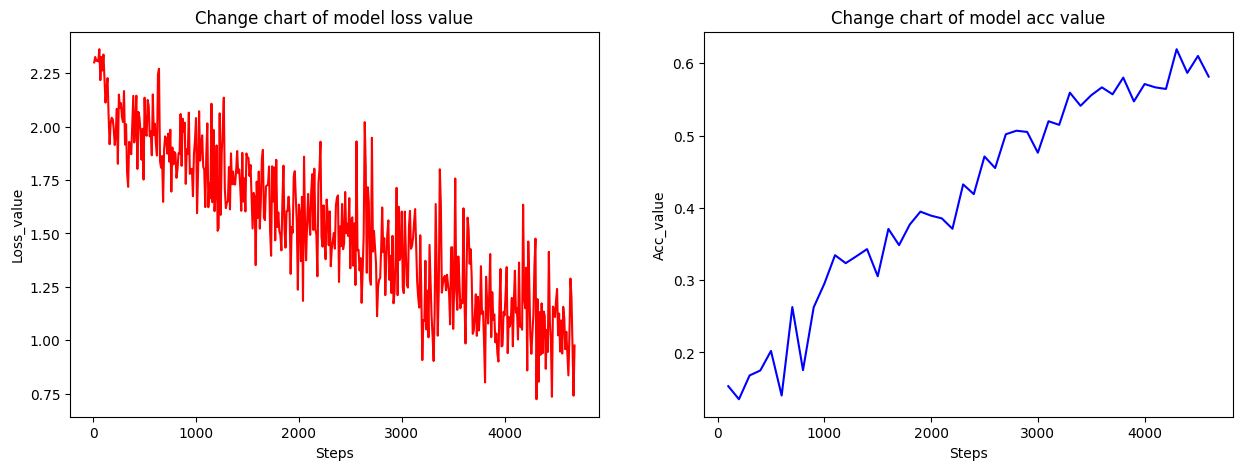

In [2]:
train("resnet18", 3)

In [ ]:
train("vgg11", 3)

begin training...
epoch: 1 step: 142, loss is 2.1479015350341797
epoch: 1 step: 284, loss is 2.0463805198669434
epoch: 1 step: 426, loss is 1.9515131711959839
epoch: 1 step: 568, loss is 1.6085407733917236
epoch: 1 step: 710, loss is 1.8757455348968506
epoch: 1 step: 852, loss is 1.7288999557495117
epoch: 1 step: 994, loss is 1.4385404586791992
epoch: 1 step: 1136, loss is 1.768000841140747
epoch: 1 step: 1278, loss is 1.402356743812561
epoch: 1 step: 1420, loss is 1.4105592966079712
epoch: 1 step: 1562, loss is 1.6992038488388062
epoch: 2 step: 142, loss is 1.207945466041565
epoch: 2 step: 284, loss is 1.6265997886657715
epoch: 2 step: 426, loss is 1.3741658926010132
epoch: 2 step: 568, loss is 1.3737837076187134
epoch: 2 step: 710, loss is 1.3584959506988525
epoch: 2 step: 852, loss is 1.2399483919143677
epoch: 2 step: 994, loss is 1.1737322807312012
epoch: 2 step: 1136, loss is 1.0593788623809814
epoch: 2 step: 1278, loss is 1.0863170623779297
epoch: 2 step: 1420, loss is 1.26004660

In [ ]:
import mindspore.nn as nn
from mindspore import  context
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as VC
from mindspore.train import Model
from mindspore.train.callback import LossMonitor
import numpy as np
from mindspore.train.callback import Callback
import matplotlib.pyplot as plt
# 设置上下文
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

# 创建 CIFAR-10 数据集的加载函数
def create_cifar10_lstm_dataset(data_path, batch_size=32,device_target="GPU"):
    # 加载 CIFAR-10 数据集
    cifar_ds = ds.Cifar10Dataset(data_path)

    # 图像转换操作
    resize_op = VC.Resize((32, 32))
    rescale_op = VC.Rescale(1.0 / 255.0, 0.0)
    normalize_op = VC.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    hwc2chw_op = VC.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)
    # 应用图像预处理操作
    cifar_ds = cifar_ds.map(operations=[resize_op, rescale_op, normalize_op, hwc2chw_op], input_columns="image")
    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label")

    # 批处理并打乱
    cifar_ds = cifar_ds.shuffle(buffer_size=5000)
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)

    return cifar_ds

# 创建 LSTM 模型
class LSTMClassifier(nn.Cell):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Dense(hidden_size, num_classes)

    def construct(self, x):
        # 将图像展平到序列形式
        batch_size, channels, height, width = x.shape
        flattened_input_size = channels * height * width

        # 展平数据并将其转换为 LSTM 所期望的形状
        x = x.view(batch_size, -1, flattened_input_size)
        
        # LSTM 前向传播
        lstm_out, _ = self.lstm(x)

        # 取最后一个时间步的输出进行分类
        output = self.fc(lstm_out[:, -1, :])

        return output

# 创建训练数据集
train_data_path = "./datasets/cifar10/train/"
train_dataset = create_cifar10_lstm_dataset(train_data_path)

'''
任务四补全
'''
# 实例化 LSTM 模型

# 定义损失函数和优化器

# 创建模型

# 训练模型

#结果可视化

